#**Install các package cần thiết**

In [1]:
!pip install joblib

In [ ]:
!pip install underthesea

#**Import các thư viện cần thiết**

In [3]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import os 
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib 
from nltk.stem import PorterStemmer
import operator 

#**Load dataset**

In [4]:
emb = None
df = pd.read_csv('/content/drive/My Drive/Course_Project_AI/dataset1.csv')
df.head(10)

,Text,Label
0,"Mình đã dùng anywhere thế hệ đầu, quả là đầy t...",0
1,"Quan tâm nhất là độ trễ có cao không, dùng thi...",0
2,"dag xài con cùi bắp 98k....pin trâu, mỗi tội đ...",0
3,logitech chắc hàng phải tiền triệu trở lên dùn...,0
4,"Đang xài con m175 cùi mía , nhà xài nhiều chuộ...",0
5,"Đang xài 2 con M185, nút chuột giữa hai con đề...",0
6,Con Anywhere 1 mình dùng bị double click cũng ...,0
7,"Hàng cty cấp, cấp xong vứt ở nhà, xài con Xorn...",0
8,"Magic mouse mà ngon hơn mới lạ, Magic mouse ch...",0
9,"em giống y bác luôn, chán bluetooth kinh hồn, ...",0


#**Visualize Dataset** 

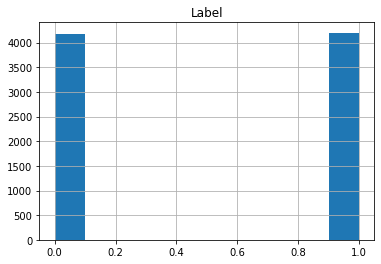

In [5]:
import matplotlib.pyplot as plt 
df.hist()
plt.show()

#**Load thêm từ điển để tăng cưỡng dữ liệu**

In [6]:
import codecs
path_nag = '/content/drive/My Drive/Course_Project_AI/nag.txt'
path_pos = '/content/drive/My Drive/Course_Project_AI/pos.txt'

with codecs.open(path_nag, 'r', encoding='UTF-8') as f:
    nag = f.readlines()
nag_list = [n.replace('\n', '') for n in nag]

with codecs.open(path_pos, 'r', encoding='UTF-8') as f:
    pos = f.readlines()
pos_list = [n.replace('\n', '') for n in pos]

#**Tiền xử lý câu**




> Chuẩn hóa dữ liệu tiếng Việt



In [7]:
def standardize_data(row):
    row = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), row, flags=re.IGNORECASE)
    row = row.lower()
    replace_list = {
        'òa': 'oà', 'óa': 'oá', 'ỏa': 'oả', 'õa': 'oã', 'ọa': 'oạ', 'òe': 'oè', 'óe': 'oé','ỏe': 'oẻ',
        'õe': 'oẽ', 'ọe': 'oẹ', 'ùy': 'uỳ', 'úy': 'uý', 'ủy': 'uỷ', 'ũy': 'uỹ','ụy': 'uỵ', 'uả': 'ủa',
        'ả': 'ả', 'ố': 'ố', 'u´': 'ố','ỗ': 'ỗ', 'ồ': 'ồ', 'ổ': 'ổ', 'ấ': 'ấ', 'ẫ': 'ẫ', 'ẩ': 'ẩ',
        'ầ': 'ầ', 'ỏ': 'ỏ', 'ề': 'ề','ễ': 'ễ', 'ắ': 'ắ', 'ủ': 'ủ', 'ế': 'ế', 'ở': 'ở', 'ỉ': 'ỉ',
        'ẻ': 'ẻ', 'àk': u' à ','aˋ': 'à', 'iˋ': 'ì', 'ă´': 'ắ','ử': 'ử', 'e˜': 'ẽ', 'y˜': 'ỹ', 'a´': 'á',
        'ô kêi': ' ok ', 'okie': ' ok ', ' o kê ': ' ok ',
        'okey': ' ok ', 'ôkê': ' ok ', 'oki': ' ok ', ' oke ':  ' ok ',' okay':' ok ','okê':' ok ',
        ' tks ': u' cám ơn ', 'thks': u' cám ơn ', 'thanks': u' cám ơn ', 'ths': u' cám ơn ', 'thank': u' cám ơn ',
        '⭐': 'star ', '*': 'star ', '🌟': 'star ', '🎉': u' positive ',
        'kg ': u' không ','not': u' không ', u' kg ': u' không ', '"k ': u' không ',' kh ':u' không ','kô':u' không ','hok':u' không ',' kp ': u' không phải ',u' kô ': u' không ', '"ko ': u' không ', u' ko ': u' không ', u' k ': u' không ', 'khong': u' không ', u' hok ': u' không ',
        'he he': ' positive ','hehe': ' positive ','hihi': ' positive ', 'haha': ' positive ', 'hjhj': ' positive ',
        ' lol ': ' nagative ',' cc ': ' nagative ','cute': u' dễ thương ','huhu': ' nagative ', ' vs ': u' với ', 'wa': ' quá ', 'wá': u' quá', 'j': u' gì ', '“': ' ',
        ' sz ': u' cỡ ', 'size': u' cỡ ', u' đx ': u' được ', 'dk': u' được ', 'dc': u' được ', 'đk': u' được ',
        'đc': u' được ','authentic': u' chuẩn chính hãng ',u' aut ': u' chuẩn chính hãng ', u' auth ': u' chuẩn chính hãng ', 'thick': u' positive ', 'store': u' cửa hàng ',
        'shop': u' cửa hàng ', 'sp': u' sản phẩm ', 'gud': u' tốt ','god': u' tốt ','wel done':' tốt ', 'good': u' tốt ', 'gút': u' tốt ',
        'sấu': u' xấu ','gut': u' tốt ', u' tot ': u' tốt ', u' nice ': u' tốt ', 'perfect': 'rất tốt', 'bt': u' bình thường ',
        'time': u' thời gian ', 'qá': u' quá ', u' ship ': u' giao hàng ', u' m ': u' mình ', u' mik ': u' mình ',
        'ể': 'ể', 'product': 'sản phẩm', 'quality': 'chất lượng','chat':' chất ', 'excelent': 'hoàn hảo', 'bad': 'tệ','fresh': ' tươi ','sad': ' tệ ',
        'date': u' hạn sử dụng ', 'hsd': u' hạn sử dụng ','quickly': u' nhanh ', 'quick': u' nhanh ','fast': u' nhanh ','delivery': u' giao hàng ',u' síp ': u' giao hàng ',
        'beautiful': u' đẹp tuyệt vời ', u' tl ': u' trả lời ', u' r ': u' rồi ', u' shopE ': u' cửa hàng ',u' order ': u' đặt hàng ',
        'chất lg': u' chất lượng ',u' sd ': u' sử dụng ',u' dt ': u' điện thoại ',u' nt ': u' nhắn tin ',u' tl ': u' trả lời ',u' sài ': u' xài ',u'bjo':u' bao giờ ',
        'thik': u' thích ',u' sop ': u' cửa hàng ', ' fb ': ' facebook ', ' face ': ' facebook ', ' very ': u' rất ',u'quả ng ':u' quảng  ',
        'dep': u' đẹp ',u' xau ': u' xấu ','delicious': u' ngon ', u'hàg': u' hàng ', u'qủa': u' quả ',
        'iu': u' yêu ','fake': u' giả mạo ', 'trl': 'trả lời', '><': u' positive ',
        ' por ': u' tệ ',' poor ': u' tệ ', 'ib':u' nhắn tin ', 'rep':u' trả lời ',u'fback':' feedback ','fedback':' feedback ',
        #dưới 3* quy về 1*, trên 3* quy về 5*
        '6 sao': ' 5star ','6 star': ' 5star ', '5star': ' 5star ','5 sao': ' 5star ','5sao': ' 5star ',
        'starstarstarstarstar': ' 5star ', '1 sao': ' 1star ', '1sao': ' 1star ','2 sao':' 1star ','2sao':' 1star ',
        '2 starstar':' 1star ','1star': ' 1star ', '0 sao': ' 1star ', '0star': ' 1star ',
    }
    for k ,v in replace_list.items():
      row = row.replace(k,v)
    row = row.replace(",", " ").replace(".", " ") \
        .replace(";", " ").replace("“", " ") \
        .replace(":", " ").replace("”", " ") \
        .replace('"', " ").replace("'", " ") \
        .replace("!", " ").replace("?", " ") \
        .replace("-", " ").replace("?", " ")      
    row = row.strip()
    return row



> Thực hiện tách từ



In [8]:
from underthesea import word_tokenize
def tok(row):
  return word_tokenize(row, format='text')



> Nhấn mạnh(tăng cường) cảm xúc trong câu



In [9]:
def data_boost(row):
  rows = row.split()
  len_ = len(rows)
  rows = [t.replace('_', ' ') for t in rows]
  for i in range(len_):
    cp_row = rows[i]
    if cp_row in pos_list:
      rows.append('positive')
    elif cp_row in nag_list:
      rows.append('nagative')
  row = u' '.join(rows)
  return row



> Xác định Parameter max_features


In [10]:
tf = TfidfVectorizer(max_features=None).fit(df['Text'])
tf.vocabulary_.__len__()

9438



> Function embedding vector hóa dữ liệu text thành vector



In [12]:
def embedding(X_train, X_test):
    global  emb
    emb = TfidfVectorizer(min_df=5, max_df=0.8,max_features=9438,sublinear_tf=True)
    emb.fit(X_train)
    X_train =  emb.transform(X_train)
    X_test = emb.transform(X_test)

    joblib.dump(emb, 'tfidf.pkl')
    return X_train, X_test



> Thực thi các hàm trên dataset



In [13]:
df['Text'] = df.Text.apply(standardize_data)
df['Text'] = df.Text.apply(tok)

In [14]:
df['Text'] = df.Text.apply(data_boost)

In [15]:
df['Text'] = df.Text.apply(tok)

#**Split Dataset**

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'], df['Label'], test_size = 0.2, random_state = 42)

In [17]:
X_train, X_test = embedding(X_train, X_test)

#**Lựa chọn và training model**

In [18]:
model = SVC(kernel='linear', C=1)
model.fit(X_train, Y_train)
joblib.dump(model, 'saved_model.pkl')

['saved_model.pkl']

In [19]:
score = model.score(X_test, Y_test)
print(score)

0.8597852028639618


#**Đánh giá Model**

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
pre = model.predict(X_test)
print(accuracy_score(Y_test, pre))
print(confusion_matrix(Y_test, pre))
print(classification_report(Y_test, pre))

0.8597852028639618
[[716 121]
 [114 725]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       837
           1       0.86      0.86      0.86       839

   micro avg       0.86      0.86      0.86      1676
   macro avg       0.86      0.86      0.86      1676
weighted avg       0.86      0.86      0.86      1676

